In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


In [12]:
# --- 1. Definition of Files ---
NODE_FILE_NAME = "../data/processed/CPFL_Paulista_2023-Nodos_R.csv"
FILE_NAME_LINKS = "../data/processed/CPFL_Paulista_2023-SSDBT_R.csv"

print(f"Loading data from {NODE_FILE_NAME} y {FILE_NAME_LINKS}...")

Loading data from ../data/processed/CPFL_Paulista_2023-Nodos_R.csv y ../data/processed/CPFL_Paulista_2023-SSDBT_R.csv...


In [13]:
# --- 2. Data Loading and Preparation ---
try:
    # Load the node file (Graph vertices)
    df_nodos = pd.read_csv(
        NODE_FILE_NAME,
        usecols=["COD_ID", "GEO_X", "GEO_Y"],
        dtype={"COD_ID": str},
    )

    df_nodos = df_nodos.rename(
        columns={
            "COD_ID": "Nodo_ID",
            "GEO_X": "Latitude",
            "GEO_Y": "Length",
        }
    )

    # Load the links file (Graph edges)
    df_links = pd.read_csv(
        FILE_NAME_LINKS,
        usecols=["COD_ID", "PN_CON_1", "PN_CON_2"],
        dtype={"COD_ID": str},
    )

    df_links = df_links.rename(
        columns={
            "COD_ID": "Link_ID",
            "PN_CON_1": "Input",
            "PN_CON_2": "Output",
        }
    )

except FileNotFoundError as e:
    print(f"ERROR: File not found {e.filename}. Check the route.")
    exit()

print("Data loaded successfully. Starting graph modeling.")


Data loaded successfully. Starting graph modeling.


In [16]:
import pandas as pd
import numpy as np
import math

# --- 1. Definición de la Función Haversine ---
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia de círculo máximo (en kilómetros) entre dos puntos 
    usando la fórmula de Haversine.
    """
    R = 6371  # Radio de la Tierra en kilómetros
    
    # Convertir grados a radianes
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Diferencias
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    # Fórmula de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distancia = R * c
    return distancia

# --- 2. Carga y Preparación de Datos (Reutilización de Estructuras) ---

# Reemplazar con la lectura real de sus archivos:
# df_nodos = pd.read_csv('Archivo_nodos.csv')
# df_links = pd.read_csv('Archivo_links.csv')

df_nodos = pd.read_csv(
        NODE_FILE_NAME,
        usecols=["COD_ID", "GEO_X", "GEO_Y"],
        dtype={"COD_ID": str},
    )

df_links = pd.read_csv(
        FILE_NAME_LINKS,
        usecols=["COD_ID", "PN_CON_1", "PN_CON_2"],
        dtype={"COD_ID": str},
    )

# Ejemplo de datos (Asumimos que ya están en memoria como en pasos previos):
# data_nodos = {'COD_ID': ['NODO_A', 'NODO_B', 'NODO_C', 'NODO_D', 'NODO_E', 'NODO_F'], 
#               'GEO_X': [-23.5, -23.6, -23.0, -22.5, -24.0, -18.0], # Latitud
#               'GEO_Y': [-46.6, -46.7, -46.5, -46.0, -47.0, -50.0]}  # Longitud
df_nodos = df_nodos.rename(columns={'GEO_X': 'Latitud', 'GEO_Y': 'Longitud'})

# data_links = {'COD_ID': ['L100', 'L101', 'L102_ERROR', 'L103', 'L104_ERROR', 'L105_ERROR'], 
#               'PN_COND_1': ['NODO_A', 'NODO_B', 'NODO_C', 'NODO_D', 'NODO_E', 'NODO_F'], 
#               'PN_CON_2': ['NODO_B', 'NODO_C', 'NODO_F', 'NODO_A', 'NODO_A', 'NODO_D']} # Simulación de 3 errores
# df_links = pd.DataFrame(data_links)

# Asegurar que los IDs sean del mismo tipo (string) para el merge
df_nodos['COD_ID'] = df_nodos['COD_ID'].astype(str)
df_links['PN_CON_1'] = df_links['PN_CON_1'].astype(str)
df_links['PN_CON_2'] = df_links['PN_CON_2'].astype(str)


# --- 3. Fusión de Datos (Uniendo Coordenadas a los Links) ---

# Fusión para el nodo de origen (PN_COND_1)
df_merged = df_links.merge(
    df_nodos, 
    left_on='PN_CON_1', 
    right_on='COD_ID', 
    suffixes=('_Link', '_Origen')
).rename(columns={'Latitud': 'Lat_Origen', 'Longitud': 'Lon_Origen'})[['COD_ID_Link', 'PN_CON_1', 'PN_CON_2', 'Lat_Origen', 'Lon_Origen']]

# Fusión para el nodo de destino (PN_CON_2)
df_final = df_merged.merge(
    df_nodos, 
    left_on='PN_CON_2', 
    right_on='COD_ID', 
    suffixes=('_Origen', '_Destino')
).rename(columns={'Latitud': 'Lat_Destino', 'Longitud': 'Lon_Destino'})

# --- 4. Cálculo de la Distancia y Filtrado ---

print("Calculando distancias de todos los enlaces...")

# Aplicar la función Haversine para obtener la distancia de cada link
df_final['Distancia_KM'] = df_final.apply(
    lambda row: haversine(
        row['Lat_Origen'], row['Lon_Origen'], 
        row['Lat_Destino'], row['Lon_Destino']
    ), axis=1
)

# Definir el umbral de error
UMBRAL_DISTANCIA_KM = 90

# Filtrar los enlaces que exceden el umbral
df_enlaces_erroneos = df_final[df_final['Distancia_KM'] > UMBRAL_DISTANCIA_KM].sort_values(by='Distancia_KM', ascending=False)


# --- 5. Presentación de Resultados ---

print("\n" + "="*50)
print(f"ENLACES ANÓMALOS IDENTIFICADOS (> {UMBRAL_DISTANCIA_KM} KM)")
print("="*50)

if df_enlaces_erroneos.empty:
    print("¡Felicidades! No se encontraron enlaces que superen el umbral de distancia.")
else:
    # Seleccionar las columnas relevantes y formatear la distancia
    resultados = df_enlaces_erroneos[[
        'COD_ID_Link', 
        'PN_CON_1', 
        'PN_CON_2', 
        'Distancia_KM'
    ]].head(10) # Mostrar los 10 principales por si hay más de 3

    resultados['Distancia_KM'] = resultados['Distancia_KM'].round(2).astype(str) + ' km'
    resultados = resultados.rename(columns={'COD_ID_Link': 'ID_LINK', 'PN_CON_1': 'NODO_ORIGEN', 'PN_CON_2': 'NODO_DESTINO'})
    
    print(resultados.to_string(index=False))

print("\nProceso de identificación de enlaces erróneos completado.")

Calculando distancias de todos los enlaces...

ENLACES ANÓMALOS IDENTIFICADOS (> 90 KM)
  ID_LINK NODO_ORIGEN NODO_DESTINO Distancia_KM
141178132     3083781    759759007    315.21 km
 17695479     2567662    759759007    202.04 km
 10097341     1919002      1559336    168.97 km
 19666412    34498126      1559336    168.94 km
 17560933     2520380      2887167     92.67 km
 17562546     2887167      2520740     92.63 km

Proceso de identificación de enlaces erróneos completado.


In [ ]:
# --- 3. Creating the Graph Model (NetworkX) ---

# For an electrical distribution network, an Undirected Graph (G) is used
# since the physical line (link) allows flow in both directions (its analysis is symmetric).

G = nx.Graph()

In [ ]:
# 3.1 Añadir Nodos
# Iteramos sobre el DataFrame de nodos para añadir cada nodo junto con sus atributos (coordenadas)
pos = {}
for item, row in df_nodos.iterrows():
    G.add_node(row["Nodo_ID"], latitude=row["Latitude"], length=row["Length"])
    
    #Guardar la posición (Longitud, Latitud) para el layout geográfico
    pos[row["Nodo_ID"]] = (row["Latitude"], row["Length"])

In [ ]:
# 3.2 Adding Edges (Links)
# We use the links DataFrame directly to add the connections.
# We assume that the link IDs (PN_CON_1 and PN_CON_2) 
# Are the same IDs in df_nodes.
# The 'Link_ID' is an attribute of the edge, not a node.

for index, row in df_links.iterrows():
    # Solo añadir el link si ambos nodos de conexión existen en el grafo
    if row["Input"] in G and row["Output"] in G:
        G.add_edge(row["Input"], row["Output"])
    else:
    # Esto ayuda a la limpieza de datos e identifica links a nodos no definidos
        print(f"Warning: The link {row["Link_ID"]} ignores connection")
        print(f"Node(s) not found: {row["Input"]} o {row["Output"]}. Ignoring.")

In [ ]:
# --- 4. Análisis Básico de la Topología ---
print("\n--- Métricas Básicas del Grafo ---")
print(f"Número total de Nodos (Subestaciones/Puntos): {G.number_of_nodes()}")
print(f"Número total de Aristas (Líneas/Links): {G.number_of_edges()}")
print(f"La red es Conexa? {'Sí' if nx.is_connected(G) else 'No'}. (Podría estar compuesta de varios componentes separados).")


--- Métricas Básicas del Grafo ---
Número total de Nodos (Subestaciones/Puntos): 2831654
Número total de Aristas (Líneas/Links): 1716859
La red es Conexa? No. (Podría estar compuesta de varios componentes separados).



Generando visualización del grafo...


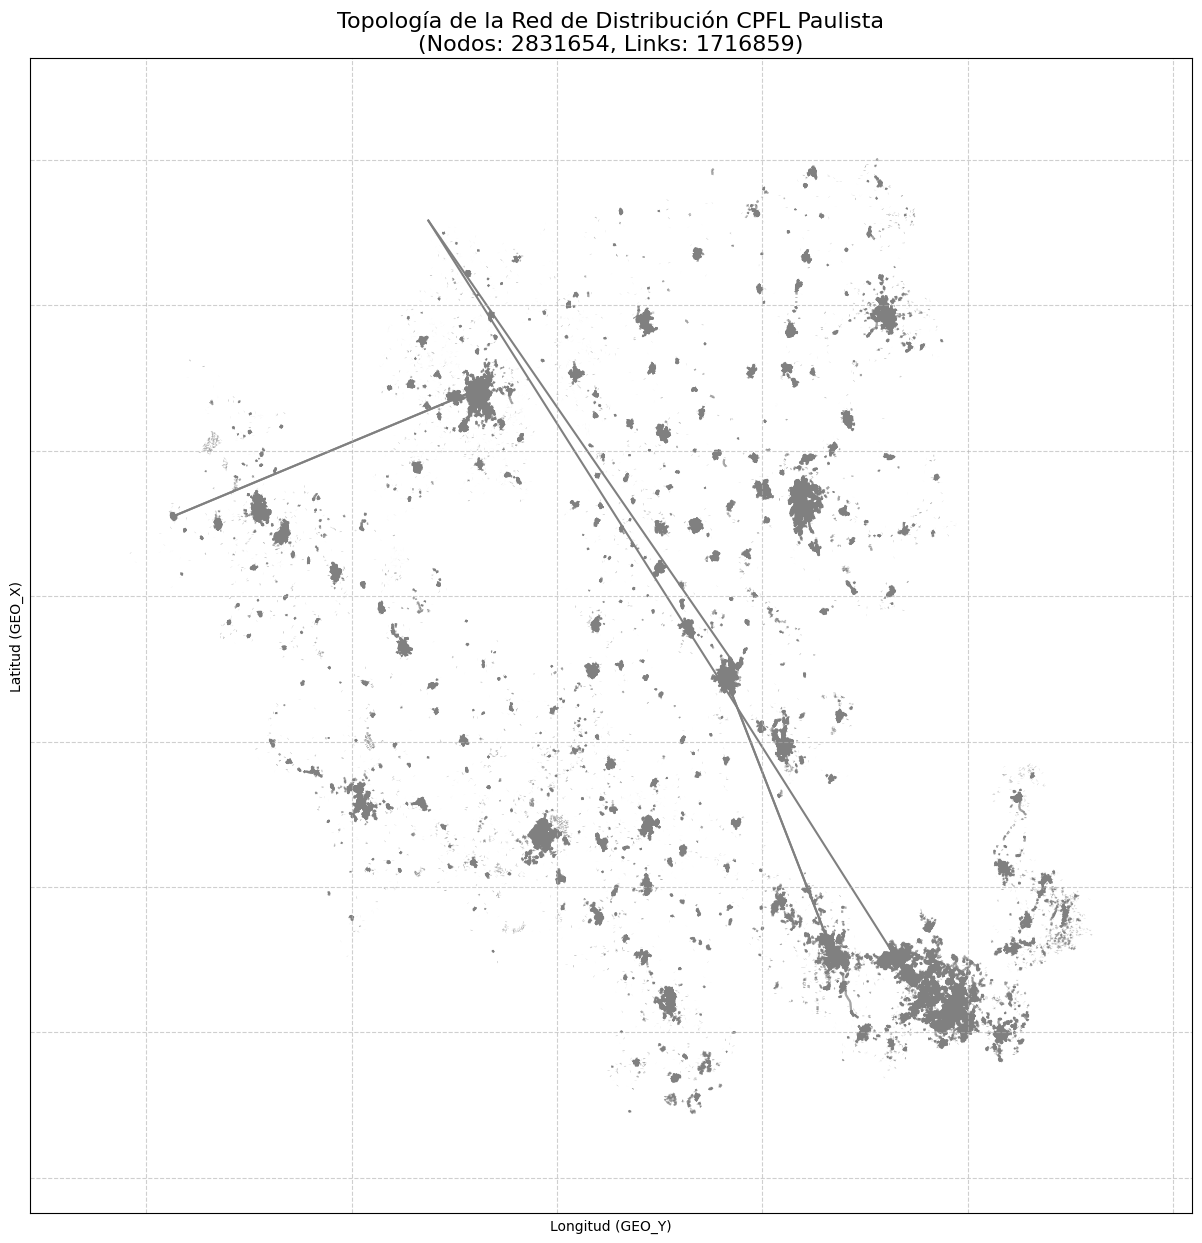

Visualización completada. Se ha generado la ventana del gráfico.

--- Próximos Pasos ---
El grafo ha sido modelado. Sugerencias para el análisis experto:
1. **Identificar Puntos Críticos (Grado):** Analizar los nodos con alto grado (mayor número de conexiones).
2. **Análisis de Componentes Conexos:** Si no es conexo, analizar cada subred por separado.
3. **Centralidad:** Calcular métricas como *Betweenness Centrality* para identificar puentes de tráfico de flujo de potencia.


In [ ]:
# --- 5. Visualización del Grafo ---

print("\nGenerando visualización del grafo...")

# 5.1 Preparar las posiciones (Layout Geográfico)
# Usamos las coordenadas GEO_X y GEO_Y para posicionar los nodos en el mapa (Layout_Pos)
# Esto da una visualización que simula la distribución geográfica real de la red.
pos = {
    nodo: (G.nodes[nodo]["latitude"], G.nodes[nodo]["length"]) for nodo in G.nodes()
}

# 5.2 Configuración de la Figura
plt.figure(figsize=(15, 15))  # Tamaño grande para una red geográfica

# 5.3 Dibujar Nodos
# Coloración basada en el grado del nodo (cuántas conexiones tiene)
# node_degrees = [G.degree(n) for n in G.nodes()]
# nx.draw_networkx_nodes(
#     G,
#     pos,
#     node_size=[v * 0.1 for v in node_degrees],  # Tamaño proporcional al grado
#     node_color=node_degrees,
#     # cmap=plt.cm.Wistia, # Paleta de colores para el grado
#     alpha=0.6,
# )

# 5.4 Dibujar Aristas
nx.draw_networkx_edges(
    G,
    pos,
    # alpha=0.9,
    edge_color="gray",
    width=1.5,
    # style='solid'
)

# 5.5 Configuración Final del Gráfico
plt.title(
    f"Topología de la Red de Distribución CPFL Paulista\n(Nodos: {G.number_of_nodes()}, Links: {G.number_of_edges()})",
    fontsize=16,
)
plt.xlabel("Longitud (GEO_Y)")
plt.ylabel("Latitud (GEO_X)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

print("Visualización completada. Se ha generado la ventana del gráfico.")

# --- 6. Próximos Pasos Analíticos Sugeridos ---
print("\n--- Próximos Pasos ---")
print("El grafo ha sido modelado. Sugerencias para el análisis experto:")
print(
    "1. **Identificar Puntos Críticos (Grado):** Analizar los nodos con alto grado (mayor número de conexiones)."
)
print(
    "2. **Análisis de Componentes Conexos:** Si no es conexo, analizar cada subred por separado."
)
print(
    "3. **Centralidad:** Calcular métricas como *Betweenness Centrality* para identificar puentes de tráfico de flujo de potencia."
)


Generando visualización del Subgrafo Geográfico...
Nodos en el subgrafo: 0
Links en el subgrafo: 0


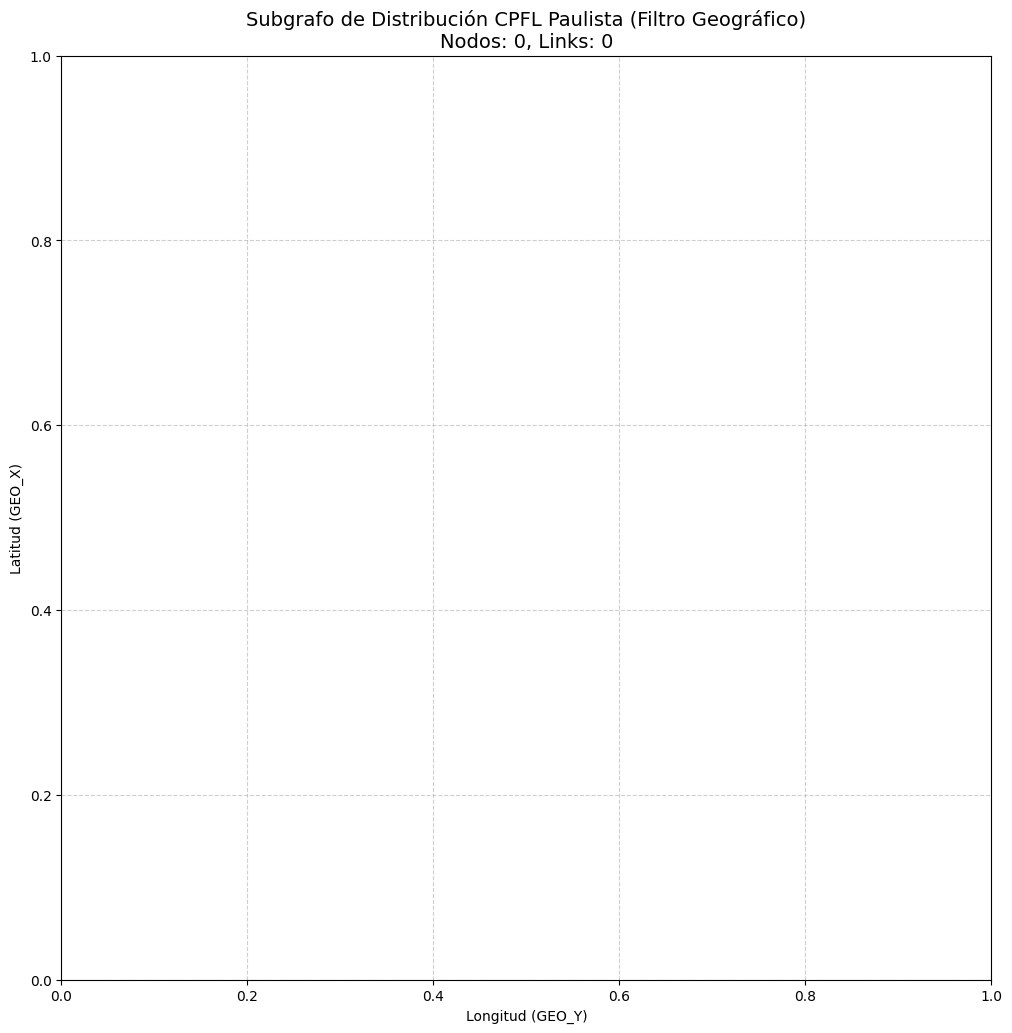

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Asumimos que G y 'pos' ya están definidos a partir de sus datos cargados.

# --- PARÁMETROS DE FILTRADO GEOGRÁFICO ---
# Defina las coordenadas del área de interés (Ej: un municipio de Campinas)
MIN_LATITUD = -23.05
MAX_LATITUD = -22.85
MIN_LONGITUD = -47.20
MAX_LONGITUD = -46.90

# --- CÁLCULO DEL SUBGRAFO ---
# 1. Identificar los nodos dentro del rango geográfico
nodos_en_area = []
for nodo, data in G.nodes(data=True):
    lat = data.get('latitude')  # Asegúrese de que el nombre del atributo sea correcto
    lon = data.get('length')    # Asegúrese de que el nombre del atributo sea correcto
    
    # Verificación de que las coordenadas existen y están en el rango
    if lat is not None and lon is not None:
        if (MIN_LATITUD <= lat <= MAX_LATITUD) and (MIN_LONGITUD <= lon <= MAX_LONGITUD):
            nodos_en_area.append(nodo)

# 2. Crear el subgrafo usando solo estos nodos
G_subgrafo = G.subgraph(nodos_en_area).copy()

# 3. Recalcular las posiciones solo para los nodos del subgrafo
pos_subgrafo = {nodo: pos[nodo] for nodo in G_subgrafo.nodes()}

# --- VISUALIZACIÓN DEL SUBGRAFO ---
print(f"\nGenerando visualización del Subgrafo Geográfico...")
print(f"Nodos en el subgrafo: {G_subgrafo.number_of_nodes()}")
print(f"Links en el subgrafo: {G_subgrafo.number_of_edges()}")

plt.figure(figsize=(12, 12))

# Configuración de los nodos del subgrafo
node_degrees_sub = [G_subgrafo.degree(n) for n in G_subgrafo.nodes()]
nx.draw_networkx_nodes(
    G_subgrafo,
    pos_subgrafo,
    node_size=[v * 10 for v in node_degrees_sub],
    node_color=node_degrees_sub,
    cmap=plt.cm.viridis,  # Nuevo colormap para mayor contraste
    alpha=0.7,
)

# Dibujar aristas del subgrafo
nx.draw_networkx_edges(
    G_subgrafo,
    pos_subgrafo,
    edge_color="blue",
    alpha=0.4,
    width=1.5,
)

# Configuración Final del Gráfico
plt.title(
    f"Subgrafo de Distribución CPFL Paulista (Filtro Geográfico)\nNodos: {G_subgrafo.number_of_nodes()}, Links: {G_subgrafo.number_of_edges()}",
    fontsize=14,
)
plt.xlabel("Longitud (GEO_Y)")
plt.ylabel("Latitud (GEO_X)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [4]:
a = ["1", "2", "3", "4", "5", "6"]
b = ["1", "3", "6", "7", "8", "9", "9"]

c = set(a).union(set(b))
print(c)

{'6', '7', '3', '4', '2', '8', '5', '1', '9'}
